<div align="right">
  Christopher Lüken-Winkels, Lukas Blecher
</div>
# Exercise 1b
## 3 Nearest Neighbor Classification on Real Data
### 3.1 Exploring the Data

In [44]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
digits = load_digits ()
print ( digits.keys () )
data = digits ["data"]
images = digits ["images"]
target = digits ["target"]
target_names = digits ["target_names"]
print ( data.dtype )
#get an image of a random "3":
threes=images[target==3] #could also use data[index].reshape((8,8)) 
img=threes[np.random.randint(len(threes))]

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
float64


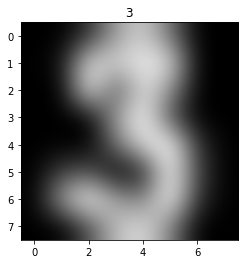

In [49]:
assert 2 == len( img.shape )
plt.figure ()
plt.gray ()
plt.imshow (img , interpolation ="bicubic") # also try interpolation =" bicubic "
plt.title('3')
plt.show ()

In [46]:
from sklearn import model_selection
X_all = data
y_all = target
X_train , X_test , y_train , y_test =\
model_selection.train_test_split ( digits .data , digits.target ,test_size = 0.4 , random_state = 0)

### 3.2 Distance function computation using loops